# 4-way Comparison
The purpose of this notebook is to compare the binomial tree (BT), Longstaff-Shwartz (LS), Approximate Dynamic Programming (ADP), and Reinforcement Learning (RL). We consider both the pricing of vanilla american put and call options. We also compare our solution to that of Black-Scholes (BS) for European put and call option pricing.

In [30]:
# # should permanantly add this path to pythonpath instead
import sys
sys.path.append(r'C:\Users\frede\MCF_Workspace\cme291-aut21\RL-book')
import matplotlib.pyplot as plt
####

from dataclasses import dataclass, replace
from typing import Callable, Tuple, Iterator, Sequence, List
import numpy as np
from rl.dynamic_programming import V
from scipy.stats import norm
from rl.markov_decision_process import MarkovDecisionProcess, State, Terminal, NonTerminal
from rl.policy import FiniteDeterministicPolicy, DeterministicPolicy
from rl.distribution import Constant, Categorical, SampledDistribution
from rl.finite_horizon import optimal_vf_and_policy
from function_approx_fred import FunctionApprox, LinearFunctionApprox, LinearInterpolationApprox,\
                                 BSplineApprox, AdamGradient  # TODO: Change to not fred?
from approximate_dynamic_programming_fred import back_opt_vf_and_policy # TODO: Change to not fred?
from rl.gen_utils.plot_funcs import plot_list_of_curves
from numpy.polynomial.laguerre import lagval

TrainingDataType = Tuple[int, float, float]

## Helper Classes and Functions

### European Option Pricing using Black-Scholes

In [2]:
def european_price(is_call: bool, strike: float, vol: float, expiry: float,
                   spot_price: float, rate: float) -> float:
    """
    Compute the price of an european option (put or call) computed using BS solution.
    """
    sigma_sqrt: float = vol * np.sqrt(expiry)
    d1: float = (np.log(spot_price / strike) +
                 (rate + vol ** 2 / 2.) * expiry) \
        / sigma_sqrt
    d2: float = d1 - sigma_sqrt
    if is_call:
        ret = spot_price * norm.cdf(d1) - \
            strike * np.exp(-rate * expiry) * norm.cdf(d2)
    else:
        ret = strike * np.exp(-rate * expiry) * norm.cdf(-d2) - \
            spot_price * norm.cdf(-d1)
    return ret

### American Option Pricing using Binomial Tree

In [3]:
@dataclass(frozen=True)
class OptimalExerciseBinTree:

    spot_price: float
    payoff: Callable[[float, float], float]
    expiry: float
    rate: float
    vol: float
    num_steps: int 

    def dt(self) -> float:
        """
        Get the time interval size used for discretization 
        """
        return self.expiry / self.num_steps

    def state_price(self, i: int, j: int) -> float:
        """
        Get the price associated with state j of time step i.
        """
        return self.spot_price * np.exp((2 * j - i) * self.vol *
                                        np.sqrt(self.dt()))

    def get_opt_vf_and_policy(self) -> \
            Iterator[Tuple[V[int], FiniteDeterministicPolicy[int, bool]]]:
        """
        Compute the optimal value functions and optimal policies for each time step by backward induction.
        """
        dt: float = self.dt()
        up_factor: float = np.exp(self.vol * np.sqrt(dt))
        up_prob: float = (np.exp(self.rate * dt) * up_factor - 1) / \
            (up_factor * up_factor - 1)
        # this step calls this function from the finite_horizon module.
        return optimal_vf_and_policy( 
            steps=[
                {NonTerminal(j): {
                    True: Constant(
                        (
                            Terminal(-1),
                            self.payoff(self.state_price(i, j))
                        )
                    ),
                    False: Categorical(
                        {
                            (NonTerminal(j + 1), 0.): up_prob,
                            (NonTerminal(j),     0.): 1 - up_prob
                        }
                    )
                } for j in range(i + 1)}
                for i in range(self.num_steps + 1)
            ],
            gamma=np.exp(-self.rate * dt)
        )

    def option_exercise_boundary(
        self,
        policy_seq: Sequence[FiniteDeterministicPolicy[int, bool]],
        is_call: bool
    ) -> Sequence[Tuple[float, float]]:
        dt: float = self.dt()
        ex_boundary: List[Tuple[float, float]] = []
        for i in range(self.num_steps + 1):
            ex_points = [j for j in range(i + 1)
                         if policy_seq[i].action_for[j] and
                         self.payoff(self.state_price(i, j)) > 0]
            if len(ex_points) > 0:
                boundary_pt = min(ex_points) if is_call else max(ex_points)
                ex_boundary.append(
                    (i * dt, self.state_price(i, boundary_pt))
                )
        return ex_boundary


### American Option Pricing using Approximate Dynamic Programming

In [4]:
# (almost) original code using linear function approximation
@dataclass(frozen=True)
class OptimalExerciseBI:
    '''Optimal Exercise with Backward Induction when the underlying
    price follows a lognormal process'''

    spot_price: float
    payoff: Callable[[float], float]
    expiry: float
    rate: float
    vol: float
    num_steps: int
    spot_price_frac: float

    def get_mdp(self, t: int) -> MarkovDecisionProcess[float, bool]:
        dt: float = self.expiry / self.num_steps
        exer_payoff: Callable[[float], float] = self.payoff
        r: float = self.rate
        s: float = self.vol

        class OptExerciseBIMDP(MarkovDecisionProcess[float, bool]):

            def step(
                self,
                price: NonTerminal[float],
                exer: bool
            ) -> SampledDistribution[Tuple[State[float], float]]:

                def sr_sampler_func(
                    price=price,
                    exer=exer
                ) -> Tuple[State[float], float]:
                    if exer:
                        return Terminal(0.), exer_payoff(price.state)
                    else:
                        next_price: float = np.exp(np.random.normal(
                            np.log(price.state) + (r - s * s / 2) * dt,
                            s * np.sqrt(dt)
                        ))
                        return NonTerminal(next_price), 0.

                return SampledDistribution(
                    sampler=sr_sampler_func,
                    expectation_samples=200 # 200
                )

            def actions(self, price: NonTerminal[float]) -> Sequence[bool]:
                return [True, False]

        return OptExerciseBIMDP()

    
    # this method is only used once in the method backward_induction_vf_and_pi. It is used 
    # to sample the states to sample to make the updates to the ADP function approx.
    # I would like to have it sample a few more outliers because the function approximation
    # tends to overfit the sample that are in a high density region. 
    def get_states_distribution( 
        self,
        t: int
    ) -> SampledDistribution[NonTerminal[float]]:
        spot_mean2: float = self.spot_price * self.spot_price
        spot_var: float = spot_mean2 * \
            self.spot_price_frac * self.spot_price_frac
        log_mean: float = np.log(spot_mean2 / np.sqrt(spot_var + spot_mean2))
        log_stdev: float = np.sqrt(np.log(spot_var / spot_mean2 + 1))

        time: float = t * self.expiry / self.num_steps

        def states_sampler_func() -> NonTerminal[float]:
            start: float = np.random.lognormal(log_mean, log_stdev) 
            price = np.exp(np.random.normal(
                np.log(start) + (self.rate - self.vol * self.vol / 2) * time,
                self.vol * np.sqrt(time)
#                 self.vol * np.sqrt(time)*1.1  # I modified this line to have more variance (added the *1.1)
            ))
            return NonTerminal(price)

        return SampledDistribution(states_sampler_func)

    def get_vf_func_approx(
        self,
        t: int,
        features: Sequence[Callable[[NonTerminal[float]], float]],
        reg_coeff: float
    ) -> LinearFunctionApprox[NonTerminal[float]]:
        return LinearFunctionApprox.create(
            feature_functions=features,
            regularization_coeff=reg_coeff,
            direct_solve=True
        )

    def backward_induction_vf_and_pi(
        self,
        features: Sequence[Callable[[NonTerminal[float]], float]],
        reg_coeff: float
    ) -> Iterator[
        Tuple[FunctionApprox[NonTerminal[float]],
              DeterministicPolicy[float, bool]]
    ]:

        mdp_f0_mu_triples: Sequence[Tuple[
            MarkovDecisionProcess[float, bool],
            FunctionApprox[NonTerminal[float]],
            SampledDistribution[NonTerminal[float]]
        ]] = [(
            self.get_mdp(t=i),
            self.get_vf_func_approx(
                t=i,
                features=features,
                reg_coeff=reg_coeff
            ),
            self.get_states_distribution(t=i)
        ) for i in range(self.num_steps + 1)]

        num_state_samples: int = 1000 #1000

        return back_opt_vf_and_policy(
            mdp_f0_mu_triples=mdp_f0_mu_triples,
            γ=np.exp(-self.rate * self.expiry / self.num_steps),
            num_state_samples=num_state_samples,
            error_tolerance=1e-8,
            mode = "put"
        )

    def optimal_value_curve(
        self,
        func: FunctionApprox[NonTerminal[float]],
        prices: Sequence[float]
    ) -> np.ndarray:
        return func.evaluate([NonTerminal(p) for p in prices])

    def exercise_curve(
        self,
        prices: Sequence[float]
    ) -> np.ndarray:
        return np.array([self.payoff(p) for p in prices])

    def put_option_exercise_boundary(
        self,
        opt_vfs: Sequence[FunctionApprox[NonTerminal[float]]],
        strike: float
    ) -> Sequence[float]:
        ret: List[float] = []
        prices: np.ndarray = np.arange(0., strike + 0.1, 0.1)
        for vf in opt_vfs[:-1]:
            cp: np.ndarray = self.optimal_value_curve(
                func=vf,
                prices=prices
            )
            ep: np.ndarray = self.exercise_curve(prices=prices)
            ll: Sequence[float] = [p for p, c, e in zip(prices, cp, ep)
                                   if e > c]
            ret.append(max(ll) if len(ll) > 0 else 0.)
        final: Sequence[Tuple[float, float]] = \
            [(p, self.payoff(p)) for p in prices]
        ret.append(max(p for p, e in final if e > 0))
        return ret


### American Option Pricing using Longstaff-Shwartz

In [5]:
@dataclass(frozen=True)
class OptimalExerciseLS:
    
    spot_price: float
    payoff: Callable[[float], float]
    expiry: float
    rate: float
    vol: float
    num_steps: int
    spot_price_frac: float # better name than spot_price_frac
       
    # TODO why do we have a spot_price_frac?
    # TODO verify that my process behaves correctly
    # TODO check that I get the same results as Prof Rao's original code
#     @memoize
    def _get_all_paths(
        self,
        spot_price_frac: float,
        num_paths: int,
        num_dt: int
    ) -> np.ndarray:
        dt = self.expiry / num_dt
        paths = np.empty([num_paths, num_dt + 1])
        spot = self.spot_price
        for i in range(num_paths):
            start = max(0.001, np.random.normal(spot, spot * spot_price_frac))
            paths[i, 0] = start
            for t in range(num_dt):
                mean = np.log(paths[i,t]) + (self.rate - self.vol * self.vol / 2) * dt
                std  = self.vol * np.sqrt(dt) 
                paths[i, t + 1] = np.exp(np.random.normal(mean, std))
        return paths


    # TODO: verify that the discount I use is OK
    # TODO: may operations could be vectorized
    def get_price(
        self,
        num_dt: int,
        num_paths: int,
        feature_funcs: Sequence[Callable[[NonTerminal[float]], float]]
    ) -> float:
        paths = self._get_all_paths(0.0, num_paths, num_dt)

        cashflow = np.array([self.payoff(paths[i,-1])
                             for i in range(num_paths)])
        dt = self.expiry / num_dt

        ex_boundary_price_range = (0,80)  # TODO: this approach won't work for call options (no need for boundary in call 
                                           #       options) Also, this is hardcoded stike price. I did change the stprcs uses
                                            # below with path_values
        stprcs = np.arange(*ex_boundary_price_range)
        final = [(p, self.payoff(p)) for p in stprcs]
        ex_boundary = [max(p for p, e in final if e > 0)]

        for step in range(num_dt - 1, 0, -1):
            """
            For each time slice t
            Step 1: collect X as features of (t, [S_0,.., S_t]) for those paths
            for which payoff(t, [S_0, ...., S_t]) > 0, and corresponding Y as
            the time-t discounted future actual cash flow on those paths.
            Step 2: Do the (X,Y) regression. Denote Y^ as regression-prediction.
            Compare Y^ versus payoff(t, [S_0, ..., S_t]). If payoff is higher,
            set cashflow at time t on that path to be the payoff, else set 
            cashflow at time t on that path to be the time-t discounted future
            actual cash flow on that path.
            """
            t = step * dt
            disc = np.exp(-self.rate * dt)
            cashflow = cashflow * disc
            payoff = np.array([self.payoff(paths[i,step]) for i in range(num_paths)])
            indices = [i for i in range(num_paths) if payoff[i] > 0]
            if len(indices) > 0:
                path_values = sorted([paths[i, step] for i in indices])
                x_vals = np.array([[f(NonTerminal(paths[i, step])) for f in feature_funcs] for i in indices])
                y_vals = np.array([cashflow[i] for i in indices])
                weights = np.linalg.lstsq(x_vals, y_vals, rcond=None)[0]
                estimate = x_vals.dot(weights)
#                 plt.scatter([paths[i, step] for i in indices], y_vals, c='r')
#                 plt.scatter([paths[i, step] for i in indices], estimate, c='b')
#                 plt.plot([paths[i, step] for i in indices], [self.payoff(paths[i, step]) for i in indices], c='g')
#                 plt.show()

                for i, ind in enumerate(indices):
                    if payoff[ind] > estimate[i]:
                        cashflow[ind] = payoff[ind]

                cp = [weights.dot([f(NonTerminal(s)) for f in feature_funcs]) for s in path_values]
                ep = [self.payoff(s) for s in path_values]
                ll = [p for p, c, e in zip(path_values, cp, ep) if e > c]
                if len(ll) == 0:
                    num = 0. # TODO: check if the following lines that I added (instead of simply setting to 0, set to previous value)
#                     if len(ex_boundary) != 0:
#                         num = ex_boundary[-1]
#                     else:
#                         num = 0
                else:
                    num = max(ll)
                ex_boundary.append(num)
                # plot the continuation and exercise value functions at step step
                if step % 10 == 0:
                    plt.title("LS Time = %.3f" % t)
                    plt.scatter([paths[i, step] for i in indices], y_vals,s=5)
                    plt.plot(path_values, cp, 'r', path_values, ep, 'b')
                    plt.show()

        return max(
            self.payoff(self.spot_price),
            np.average(cashflow * np.exp(-self.rate * dt))
        ), ex_boundary[::-1] #TODO: I think I have reversed it
                       #TODO: only have the exercise boundary if it is a put option




### American Option Pricing using Reinforcement Learning

In [22]:

@dataclass(frozen=True)
class OptimalExerciseRL:

    spot_price: float
    payoff: Callable[[float], float]
    expiry: float
    rate: float
    vol: float
    num_steps: int 
        
    def training_sim_data(
        self,
        num_paths: int,
        spot_price_frac: float
    ) -> Sequence[TrainingDataType]:
        ret: List[TrainingDataType] = []
        dt: float = self.expiry / self.num_steps
        spot: float = self.spot_price
        vol2: float = self.vol * self.vol

        mean2: float = spot * spot
        var: float = mean2 * spot_price_frac * spot_price_frac
        log_mean: float = np.log(mean2 / np.sqrt(var + mean2))
        log_stdev: float = np.sqrt(np.log(var / mean2 + 1))

        for i in range(num_paths):
            price: float = np.random.lognormal(log_mean, log_stdev)
            for step in range(self.num_steps):
                m: float = np.log(price) + (self.rate - vol2 / 2) * dt
                v: float = vol2 * dt
                next_price: float = np.exp(np.random.normal(m, np.sqrt(v)))
                ret.append((step, price, next_price))
                price = next_price
        return ret
    
    def scoring_sim_data(self, num_paths: int) -> np.ndarray:
        paths: np.ndarray = np.empty([num_paths, self.num_steps + 1])
        dt: float = self.expiry / self.num_steps
        vol2: float = self.vol * self.vol
        for i in range(num_paths):
            paths[i, 0] = self.spot_price
            for step in range(self.num_steps):
                m: float = np.log(paths[i, step]) + (self.rate - vol2 / 2) * dt
                v: float = vol2 * dt
                paths[i, step + 1] = np.exp(np.random.normal(m, np.sqrt(v)))
        return paths
    
    def linear_func_approx(
        self,
        features: Sequence[Callable[[Tuple[float, float]], float]],
        reg: float
    ) -> LinearFunctionApprox[Tuple[float, float]]:
        return LinearFunctionApprox.create(
            feature_functions=features,
            adam_gradient=self.adam_gradient(),
            regularization_coeff=reg
        )
    
    def adam_gradient(self) -> AdamGradient:
        return AdamGradient(
            learning_rate=0.1,
            decay1=0.9,
            decay2=0.999
        )
    
    def train_lspi(
        self,
        training_data: Sequence[TrainingDataType],
        init_fa: LinearFunctionApprox[Tuple[float, float]],
        training_iters: int,
        split: int
    ) -> LinearFunctionApprox[Tuple[float, float]]:
        fa: LinearFunctionApprox[Tuple[float, float]] = init_fa
        dt: float = self.expiry / self.num_steps
        gamma: float = np.exp(-self.rate * dt)
        num_features: int = len(fa.feature_functions)
        states: Sequence[Tuple[float, float]] = [(i * dt, s) for
                                                 i, s, _ in training_data]
        next_states: Sequence[Tuple[float, float]] = \
            [((i + 1) * dt, s1) for i, _, s1 in training_data]
        features: np.ndarray = fa.get_feature_values(states)
        next_features: np.ndarray = fa.get_feature_values(next_states)
        non_terminal: np.ndarray = np.array(
            [i < self.num_steps - 1 for i, _, _ in training_data]
        )
        exer: np.ndarray = np.array([self.payoff(s1)
                                     for t1, s1 in next_states])
        reg_mat: np.ndarray = fa.regularization_coeff * \
            np.eye(len(fa.feature_functions))
        for i in range(training_iters):
            a_mat: np.ndarray = np.zeros([num_features, num_features])
            b_vec: np.ndarray = np.zeros(num_features)
            cont: np.ndarray = fa.evaluate(next_states)
            cont_cond: np.ndarray = non_terminal * (cont > exer)
            features_split: Sequence[np.ndarray] = \
                np.array_split(features, split)
            next_features_split: Sequence[np.ndarray] = \
                np.array_split(next_features, split, axis=0)
            cont_cond_split: Sequence[np.ndarray] = \
                np.array_split(cont_cond, split)
            exer_split: Sequence[np.ndarray] = np.array_split(exer, split)
            for i in range(split):
                a_mat += features_split[i].T.dot(
                    features_split[i] - np.diag(cont_cond_split[i]).dot(
                        next_features_split[i] * gamma
                    )
                )
                b_vec += features_split[i].T.dot(
                    (1 - cont_cond_split[i]) * exer_split[i] * gamma
                )
            a_mat /= len(training_data)
            a_mat += reg_mat
            b_vec /= len(training_data)
            wts: np.ndarray = np.linalg.solve(a_mat, b_vec)
            fa = replace(
                fa,
                weights=replace(
                    fa.weights,
                    weights=wts
                )
            )
        return fa
    
    def continuation_curve(
        self,
        func: FunctionApprox[Tuple[float, float]],
        step: int,
        prices: Sequence[float]
    ) -> np.ndarray:
        t: float = step * self.expiry / self.num_steps
        return func.evaluate([(t, p) for p in prices])
    
    def exercise_curve(
        self,
        step: int,
        prices: Sequence[float]
    ) -> np.ndarray:
        t: float = step * self.expiry / self.num_steps
        return np.array([self.payoff(p) for p in prices])

    def put_option_exercise_boundary(
        self,
        func: FunctionApprox[Tuple[float, float]],
        strike: float
    ) -> Sequence[float]:
        ret: List[float] = []
        prices: np.ndarray = np.arange(0., strike + 0.1, 0.1)
        for step in range(self.num_steps):
            cp: np.ndarray = self.continuation_curve(
                func=func,
                step=step,
                prices=prices
            )
            ep: np.ndarray = self.exercise_curve(step=step, prices=prices)
            ll: Sequence[float] = [p for p, c, e in zip(prices, cp, ep)
                                   if e > c]
            ret.append(max(ll) if len(ll) > 0 else 0.)
        final: Sequence[Tuple[float, float]] = \
            [(p, self.payoff(p)) for p in prices]
        ret.append(max(p for p, e in final if e > 0))
        return ret
    
    def option_price(
        self,
        scoring_data: np.ndarray,
        func: FunctionApprox[Tuple[float, float]]
    ) -> float:
        num_paths: int = scoring_data.shape[0]
        prices: np.ndarray = np.zeros(num_paths)
        dt: float = self.expiry / self.num_steps

        for i, path in enumerate(scoring_data):
            step: int = 0
            while step <= self.num_steps:
                t: float = step * dt
                exercise_price: float = self.payoff(path[step])
                continue_price: float = func.evaluate([(t, path[step])])[0] \
                    if step < self.num_steps else 0.
                step += 1
                if exercise_price >= continue_price:
                    prices[i] = np.exp(-self.rate * t) * exercise_price
                    step = self.num_steps + 1

        return np.average(prices)
    
    
def fitted_lspi_put_option(
    obj: OptimalExerciseRL,
    strike: float,
    expiry: float,
    training_data: Sequence[TrainingDataType],
    training_iters: int,
    split: int
) -> LinearFunctionApprox[Tuple[float, float]]:

    num_laguerre: int = 3
    lspi_reg: float = 0.001

    ident: np.ndarray = np.eye(num_laguerre)
    features: List[Callable[[Tuple[float, float]], float]] = [lambda _: 1.]
    features += [(lambda t_s: np.exp(-t_s[1] / (2 * strike)) *
                  lagval(t_s[1] / strike, ident[i]))
                 for i in range(num_laguerre)]
    features += [
        lambda t_s: np.cos(-t_s[0] * np.pi / (2 * expiry)),
        lambda t_s: np.log(expiry - t_s[0]) if t_s[0] != expiry else 0.,
        lambda t_s: (t_s[0] / expiry) ** 2
    ]

    linear_approx: LinearFunctionApprox[Tuple[float, float]] = \
        obj.linear_func_approx(features=features, reg=lspi_reg)

    return obj.train_lspi(
        training_data=training_data,
        init_fa=linear_approx,
        training_iters=training_iters,
        split=split
    )


## Perform the pricing (with Linear Function Approximation)

### problem setting

In [28]:
# global parameters
spot_price_val: float = 100.0 #100.0
strike_val: float = 100.0 #100.0
is_call_val: bool = False  #False
expiry_val: float = 1.0 #1.0
rate_val: float = 0.05 #0.05
vol_val: float = 0.25 #0.25
spot_price_frac_val: float = 0.02
seed_val = 0
# algo. specific parameters
num_steps_val_best: int = 1000 #300
num_steps_val_bin_tree: int = 300 #300
num_steps_val_adp: int = 2 #10
num_steps_val_ls: int = 100 #300
num_paths_val_ls = 1000 #10000
num_steps_val_rl: int = 5 #300
num_training_paths_val_rl: int = 5000 #5000
num_scoring_paths_val_rl: int = 10000 #10000
num_training_iters_val_rl: int = 8 #8
split_val_rl: int = 1000#1000

# set random seed
np.random.seed(seed_val)
    
# define different payoffs if call or put option
if is_call_val:
    opt_payoff: Callable[[float],float] = lambda x: max(x - strike_val, 0)
else:
    opt_payoff: Callable[[float],float] = lambda x: max(strike_val - x, 0)

# define the features to use for the linear function approximation
num_laguerre_val: int = 4 # 4
reglr_coeff_val: float = 0.01 #0.001 (I should play with that)

# define my feature functions (laguerre polynomials)
def laguerre_feature_func(
    s: NonTerminal[float],
    i: int,
    n: int,
    strike: float
) -> float:
    xp = s.state / strike
    coef = np.zeros((n,))
    coef[i] = 1
    return np.exp(-xp / 2) * lagval(xp, coef)

ffs: List[Callable[[NonTerminal[float]], float]] = [lambda _: 1.]
for i in range(num_laguerre_val):
    ff = lambda s,i=i: laguerre_feature_func(s,i,num_laguerre_val,strike_val)
    ffs += [ff]
    

### price european option with Black-Scholes

In [7]:
price_bs: float = european_price(is_call_val, strike_val, vol_val, expiry_val, spot_price_val, rate_val)

### price american option with BEST model (Binary Tree with many steps)

In [8]:
opt_ex_best: OptimalExerciseBinTree = OptimalExerciseBinTree(
    spot_price=spot_price_val,
    payoff=opt_payoff,
    expiry=expiry_val,
    rate=rate_val,
    vol=vol_val,
    num_steps=num_steps_val_best
)


    
# get the optimal value functions and policy for each time step using backward induction
vf_seq_best, policy_seq_best = zip(*opt_ex_best.get_opt_vf_and_policy())

# get the exercise boundary
ex_boundary_best: Sequence[Tuple[float, float]] = \
    opt_ex_best.option_exercise_boundary(policy_seq_best, is_call_val)

### price american option with Binary Tree model

In [9]:
opt_ex_bin_tree: OptimalExerciseBinTree = OptimalExerciseBinTree(
    spot_price=spot_price_val,
    payoff=opt_payoff,
    expiry=expiry_val,
    rate=rate_val,
    vol=vol_val,
    num_steps=num_steps_val_bin_tree
)
    
# get the optimal value functions and policy for each time step using backward induction
vf_seq_bin_tree, policy_seq_bin_tree = zip(*opt_ex_bin_tree.get_opt_vf_and_policy())

# get the exercise boundary
ex_boundary_bin_tree: Sequence[Tuple[float, float]] = \
    opt_ex_bin_tree.option_exercise_boundary(policy_seq_bin_tree, is_call_val)

### price american option with ADP

In [10]:
opt_ex_adp: OptimalExerciseBI = OptimalExerciseBI(
    spot_price=spot_price_val,
    payoff=opt_payoff,
    expiry=expiry_val,
    rate=rate_val,
    vol=vol_val,
    num_steps=num_steps_val_adp,
    spot_price_frac=spot_price_frac_val
)

it_vf_adp = opt_ex_adp.backward_induction_vf_and_pi(
    features=ffs,
    reg_coeff=reglr_coeff_val
)
it_vf_adp = list(it_vf_adp)

### price american option with LS

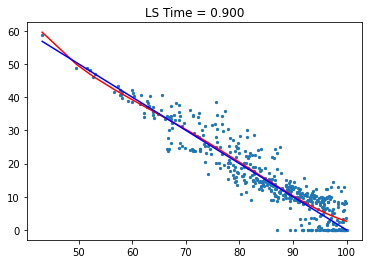

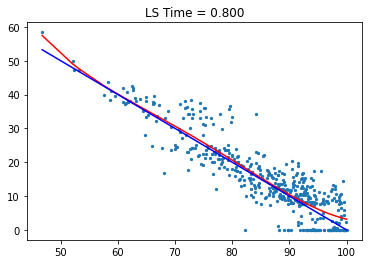

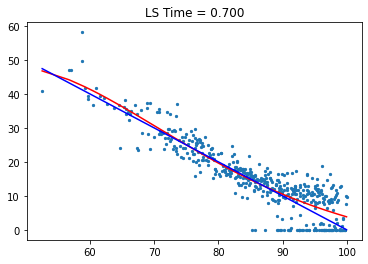

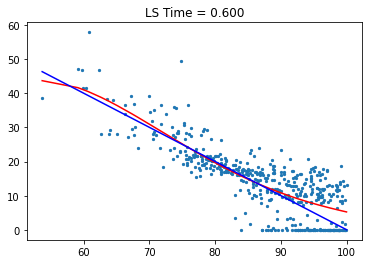

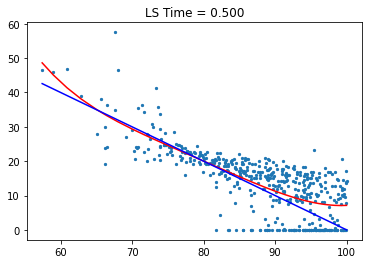

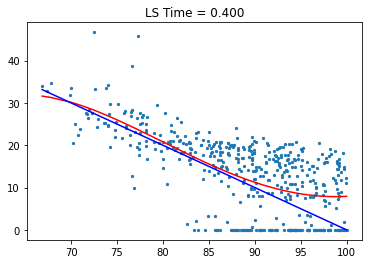

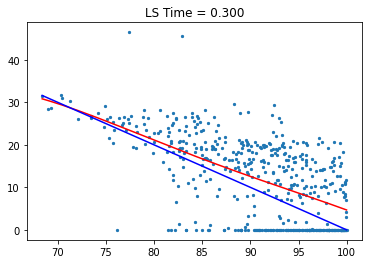

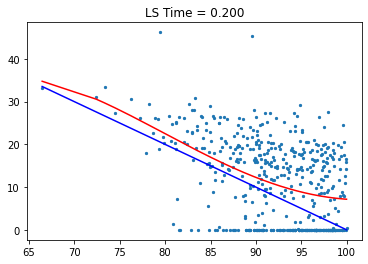

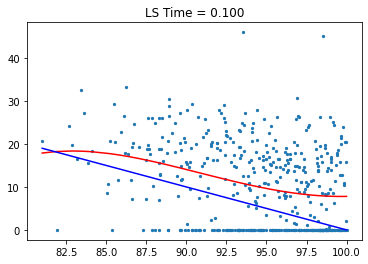

In [11]:
# instantiate the OptimalExerciseLS class which computes price and exercise boundary
opt_ex_ls: OptimalExerciseLS = OptimalExerciseLS(
                                    spot_price = spot_price_val,
                                    payoff = opt_payoff,
                                    expiry = expiry_val,
                                    rate = rate_val,
                                    vol = vol_val,
                                    num_steps = num_steps_val_ls,
                                    spot_price_frac = spot_price_frac_val)
        
# get price
price_ls, ex_boundary_ls = opt_ex_ls.get_price(num_steps_val_ls, num_paths_val_ls, ffs)
    


### price american option with RL

In [32]:
# instantiate the class
opt_ex_rl: OptimalExerciseRL = OptimalExerciseRL(
    spot_price=spot_price_val,
    payoff=opt_payoff,
    expiry=expiry_val,
    rate=rate_val,
    vol=vol_val,
    num_steps=num_steps_val_rl
)

# generate training data
training_data: Sequence[TrainingDataType] = opt_ex_rl.training_sim_data(
    num_paths=num_training_paths_val_rl,
    spot_price_frac=spot_price_frac_val
)

# fit the model on the training data
flspi: LinearFunctionApprox[Tuple[float, float]] = fitted_lspi_put_option(
    obj=opt_ex_rl,
    strike=strike_val,
    expiry=expiry_val,
    training_data=training_data,
    training_iters=num_training_iters_val_rl,
    split=split_val_rl
)

# get the exercise boundary
ex_boundary_rl: Sequence[float] = opt_ex_rl.put_option_exercise_boundary(
    func=flspi,
    strike=strike_val
)

# generate testing data
scoring_data: np.ndarray = opt_ex_rl.scoring_sim_data(
    num_paths=num_scoring_paths_val_rl
)

# get the price 
price_rl: float = opt_ex_rl.option_price(
    scoring_data=scoring_data,
    func=flspi
)


It should just be 
- initialize class performs the pricing
    - it stores the opt_ex_boundary and the optimal value functions
- 2 getters
    - get_opt_vf(self, step: int) -> Tuple[List[State[float]], List[float]] 
    - get_opt_ex_boundary(self) -> Tuple[List[float], List[State[float]]]

### Compare the exercise boundaries

Black-Scholes European Option Price = 7.459

Best Model American Option Price = 7.973

Binary Tree American Option Price = 7.971

ADP American Option Price = 10.83317

Longstaff-Schwartz American Option Price = 7.88209

RL American Option Price = 7.529



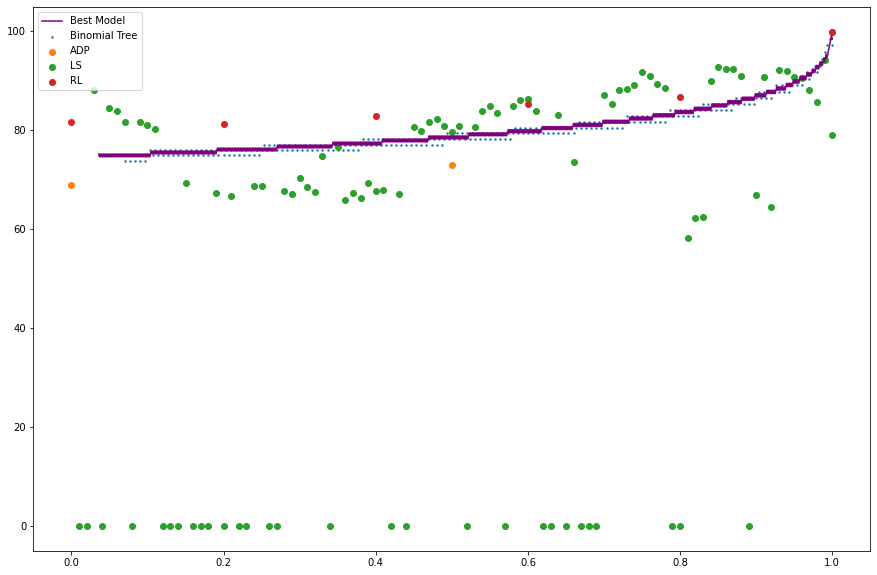

In [35]:
# Black-Scholes
print(f"Black-Scholes European Option Price = {price_bs:.3f}\n")

# for plotting
plt.figure(figsize=(15,10))

# Best model
ex_boundary_xs_best, ex_boundary_ys_best = zip(*ex_boundary_best)
plt.plot(ex_boundary_xs_best, ex_boundary_ys_best, label="Best Model", color = "purple")
# print the price of the american option (VF at state 0, at time 0)
# price_best: float = vf_seq_best[0][NonTerminal(0)]
price_best: float = vf_seq_best[0][NonTerminal(0)]
print(f"Best Model American Option Price = {price_best:.3f}\n")

# Binary Tree
ex_boundary_xs_bin_tree, ex_boundary_ys_bin_tree = zip(*ex_boundary_bin_tree)
plt.scatter(ex_boundary_xs_bin_tree, ex_boundary_ys_bin_tree, s = 2, label="Binomial Tree")
# print the price of the american option (VF at state 0, at time 0)
# price_bin_tree: float = vf_seq_bin_tree[0][NonTerminal(0)]
price_bin_tree: float = vf_seq_bin_tree[0][NonTerminal(0)]
print(f"Binary Tree American Option Price = {price_bin_tree:.3f}\n")

# ADP
all_funcs: List[FunctionApprox[NonTerminal[float]]] = []
for t, (v_opt, v_cont, v_exec, p) in enumerate(it_vf_adp):
    all_funcs.append(v_opt)
    price_adp: float = v_opt(NonTerminal(spot_price_val))

ex_boundary_adp: Sequence[float] = opt_ex_adp.put_option_exercise_boundary(
    all_funcs,
    strike_val
)
dt_adp = expiry_val / num_steps_val_adp
plt.scatter([t * dt_adp for t in range(0, num_steps_val_adp + 1)], ex_boundary_adp, label="ADP")
print("ADP American Option Price = %.5f\n" % price_adp)

# LS
dt_ls = expiry_val / num_steps_val_ls
plt.scatter([t * dt_ls for t in range(1, num_steps_val_ls + 1)], ex_boundary_ls, label="LS")
print("Longstaff-Schwartz American Option Price = %.5f\n" % price_ls)

# RL
dt_rl: float = expiry_val / num_steps_val_rl
plt.scatter([i * dt_rl for i in range(num_steps_val_rl + 1)], ex_boundary_rl, label="RL")
print(f"RL American Option Price = {price_rl:.3f}\n")

# show the plot
plt.legend(loc="best")
plt.show()



In [13]:
vf_seq_best[0]

{NonTerminal(state=0): 7.97343877287018}

### Compare the Optimal Value Functions at each 10% time steps

## Helper Functions (up there)
- Define my metric
- Define a function to overlay all 3 exercise boundaries

# TODO
- create a README for these notebooks
    - the README should say that in order to use the notebook, one must clone the code from rl book and put it in this floder
    - the readme folder should also explicitely cite the RL book and Ashwin's code
    - it should explain that I am the student and that Ashwin is the supervisor
- **make the code so that I only get back the vfs at each step and the exercise boundary for each approach.**
    - the name of the function should be the same for all (same interface)
- remove the plots from the LS code
- define the metric (as a function) and have the true exercise curve and the ex curve to evaluate as arguments
- fix the Bin tree approach, I believe that it is broken because the rate is between steps and not time, which is why it drops so fast with many steps.
- fix the fact that binary tree takes state as number while, others have states as price... or is it really an issue?

## Notes:
- Remove all the spurious dependance and the NonTerminal() things, I woul like this code to be self-contained
- In ADP, have an argument that selects the approach with possibility to select from all the approach I have used (Lstsq with laguerre poly, linear interpolation, bspline, an maybe locally weighted lstsq
- compute the execution time of each approach, maybe as a function or their parameters
- use the metric to compute how close the execution boundary are to binomial tree
- should discuss next steps in my analysis:
    - develop a more general methodology for ADP because now I rely on choosing the s to better fit the bin tree solution
    

## Questions:
- Longstaff shwartz gives a good price, but the ex_boundary is off. When increasing the number of traces it gets better.
- How should I go about comparing the 3 approaches, they all have different parameters, different execution times, different ex boundary depending on the parameters chosen...

## Meeting with Prof Rao
- provide a perspective to what makes ls work well on both conceptual and technical level
- what can we learn about it, and how could this learning maybe create a RL algorithm that would potentially be better than LS
- make the 3 way comparison
    - problem in comparison
        - bin